In [1]:
import openai
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from googlesearch import search
from docx import Document

import re
import requests
import nltk
import spacy

In [2]:
%cd ..

with open('private.txt', 'r') as f:
    content = f.read()
    key = re.findall(r'\'.*?\'', content)[0].strip('\'')
    openai.api_key = key
f.close()

%cd experiment    

h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp
h:\Andere Computer\Mein Computer\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp\experiment


# Utility

In [3]:
def parse_date_from_html(html_string):
    "parse date from html. Input html as byte object. The output is a string."
    try:
        regex = b"\d{4}-\d{2}-\d{2}" # b stands for byte like! not a string yet
        date = re.search(regex, html_string)[0]
        date_string = date.decode('utf-8') # turn to string
    except:
        try:
            regex = b"\d{4}\/\d{2}\/\d{2}" # b stands for byte like! not a string yet
            date = re.search(regex, html_string)[0]
            date_string = date.decode('utf-8')#.replace("/", "-") # turn to string
        except:
            date_string = 'no date detected'
    return date_string

def parse_title_from_html(html_string):
    "parse_title_from_html. Input html as byte object. The output is a string."
    try:
        title = re.search(b'<title>(.*?)</title>', html_string).group(1)
        title = title.decode('utf-8')
        title = title.split('.')[0].split('&')[0].split('|')[0].split('-')[0]
    except:
        title = 'no title detected'
    return title

def google_query(keywords, num_results=10):
  "query google by topics and return the url, the title and the publication date for each search result as lists"
  source_google = []
  titles_google = []
  publication_dates_google = []

  for kw in keywords:
    query = kw
    for url in search(query, num_results, lang="de"):
        # get html string
        html_string = requests.get(url).content     
        # get title
        title = parse_title_from_html(html_string)
        # get date
        date = parse_date_from_html(html_string)
        # save results in lists
        source_google.append(url)
        titles_google.append(title)
        publication_dates_google.append(date)

        print(url)  
        print(title)
        print(date)

  return source_google, titles_google, publication_dates_google

# Define Keywords

In [4]:
# define key words
keywords = ['Finanzielle Hilfe im Alter', 
            'Rentner in Not',
            'Armut Senioren',
            'Altersarmut Frauen',
            'Renten Pay-Gap',
            'Unterstützung Rentner']

# Generate Topic List 

## Generate Topics from Latest Article Headlines Found by Google Search

In [6]:
# get google search results for each topic
source_google, titles_google, publication_dates_google = google_query(keywords, num_results=10)

https://familienportal.de/familienportal/lebenslagen/alter/staatliche-leistungen
Staatliche Leistungen im Alter 
no date detected
https://www.caritas.de/hilfeundberatung/ratgeber/alter/pflege/finanzielle-hilfe-wenn-die-rente-nicht-reicht
Finanzielle Hilfe wenn die Rente nicht reicht
2021-10-04
https://www.kennstdueinen.de/magazin/geldnot-im-alter-welche-finanziellen-hilfen-gibt-es-wenn-die-rente-nicht-reicht/
Geldnot im Alter 
2015-09-04
https://www.seniorenlebenshilfe.de/dienstleistungen-fuer-senioren/grundsicherung-im-alter/
Wichtige Infos zur Grundsicherung im Alter 
2021-07-13
https://www.focus.de/finanzen/altersvorsorge/staatliche-unterstuetzung-viel-mehr-geld-im-alter-sieben-lohnende-zuschuesse-fuer-rentner_id_8970984.html
Viel mehr Geld im Alter: Sechs lohnende Zuschüsse für Rentner 
2018-05-25
https://www.serviceportal-zuhause-im-alter.de/wohnen/laenger-zuhause-wohnen/finanzielle-foerderung.html
Finanzielle Förderung 
no date detected
https://www.einherzfuerrentner.de/fuer-rent

In [7]:
#source_google = []
#titles_google = []
#publication_dates_google = []
len(publication_dates_google)

63

In [7]:
# turn titles and sources into dataframe
df_titles_google = pd.DataFrame({'source': source_google, 'title': titles_google, 'date': publication_dates_google})
df_titles_google.head(10)

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
5,https://www.serviceportal-zuhause-im-alter.de/...,Finanzielle Förderung,no date detected
6,https://www.einherzfuerrentner.de/fuer-rentner/,Für Rentner,2023-02-02
7,https://www.betanet.de/sozialhilfe-altenhilfe....,Sozialhilfe > Altenhilfe,no date detected
8,https://www.ihre-vorsorge.de/magazin/lesen/wen...,Wenn das Geld im Alter nicht reicht: Finanziel...,2023-02-27
9,https://seniorenhilfe-lichtblick.de/,LichtBlick Seniorenhilfe e,2023-02-15


## Generate Topics Based on ChatGPT

In [8]:
instruction = \
"Nenne zu folgenden Keywords " + '\n' \
'keywords = ' + str(keywords)  + '\n' \
'20 Themenüberschriften.'
print('Instruction: ', instruction)

Instruction:  Nenne zu folgenden Keywords 
keywords = ['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
20 Themenüberschriften.


In [9]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

titles_chatgpt = response['choices'][0].text

# format titles and put into list
titles_chatgpt = [title.strip().replace("\n", "").replace(". ", "") for title in re.split(r'\d+', titles_chatgpt)]

In [10]:
# turn titles and sources into dataframe
date_today = datetime.date.today().strftime("%Y-%m-%d")
df_titles_chatgpt = pd.DataFrame({'source': 'chatgpt', 'title': titles_chatgpt, 'date': date_today})
df_titles_chatgpt.head(10)

,source,title,date
0,chatgpt,,2023-02-27
1,chatgpt,Finanzielle Unterstützung für Rentner: Wie kön...,2023-02-27
2,chatgpt,Armut im Alter: Eine Herausforderung für Senioren,2023-02-27
3,chatgpt,Altersarmut bei Frauen: Was können wir tun?,2023-02-27
4,chatgpt,Renten Pay-Gap: Warum sind die Unterschiede so...,2023-02-27
5,chatgpt,Unterstützung für Rentner: Welche Möglichkeite...,2023-02-27
6,chatgpt,Finanzielle Hilfe im Alter – Wie kann man aufb...,2023-02-27
7,chatgpt,Rentner in Not: Woher kommt die Unterstützung?,2023-02-27
8,chatgpt,Armut bei Senioren – Wie schaffen wir Abhilfe?,2023-02-27
9,chatgpt,"Altersarmut bei Frauen – ein Problem, das nich...",2023-02-27


In [11]:
# concat both title dataframes
df_titles = df_titles_google.append(df_titles_chatgpt)
df_titles

C:\Users\Sebas\AppData\Local\Temp\ipykernel_22100\473715585.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_titles = df_titles_google.append(df_titles_chatgpt)


,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
...,...,...,...
16,chatgpt,Der Renten Pay-Gap und seine Auswirkungen auf ...,2023-02-27
17,chatgpt,Unterstützung für Rentner – Welche Lösungsansä...,2023-02-27
18,chatgpt,Finanzielle Hilfe im Alter – Eine notwendige M...,2023-02-27
19,chatgpt,Rentner in Not: Wie kann man ihnen helfen?,2023-02-27


## Apply Topic-Keyword Similarity Filter

In [12]:
nlp = spacy.load("de_core_news_lg")

In [13]:
# measure similarity between the titles and the keywords
title_keyword_similarity = []
for title in df_titles['title']:
  sim_score = 0
  for kw in keywords:
    sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability
  # append sum of similarity scores
  title_keyword_similarity.append(np.round(sim_score, 2))

C:\Users\Sebas\AppData\Local\Temp\ipykernel_22100\4193192492.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability


In [14]:
# Add title-keyword similarity scores to df_titles
df_titles['keyword_similarity'] = title_keyword_similarity
df_titles.head()

,source,title,date,keyword_similarity
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected,0.40
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04,0.40
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04,0.33
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13,0.30
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25,0.39


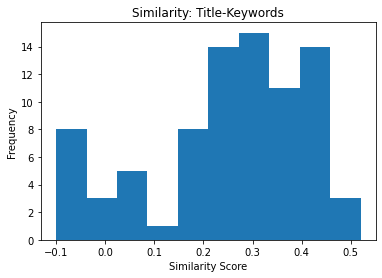

In [15]:
# show title-similarity distribution
plt.hist(df_titles['keyword_similarity'])
plt.title('Similarity: Title-Keywords')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
# filter out similarity score < 0.1
df_titles = df_titles[df_titles['keyword_similarity'] > 0.1]
df_titles = df_titles.sort_values(by='keyword_similarity', ascending=False, ignore_index=True)
df_titles

,source,title,date,keyword_similarity
0,https://www.viele-schaffen-mehr.de/projekte/hi...,Finanzielle Hilfe für Rentner in Not,no date detected,0.52
1,https://frauen.verdi.de/themen/rente/++co++c0b...,Frauen haben niedrigere Renten – ver,no date detected,0.46
2,https://www.wn.de/muenster/immer-mehr-rentner-...,Immer mehr Rentner in Not,2022-10-07,0.46
3,https://www.destatis.de/DE/Themen/Querschnitt/...,Armutsgefährdung sowie materielle und soziale ...,2022-08-23,0.44
4,https://www.deutsche-rentenversicherung.de/DRV...,Grundsicherung,2022-04-30,0.43
...,...,...,...,...
61,chatgpt,Renten Pay-Gap: Warum sind die Unterschiede so...,2023-02-27,0.18
62,https://www.dza.de/detailansicht/im-arbeitsleb...,Im Arbeitsleben und im Ruhestand: gravierende ...,2022-10-18,0.18
63,chatgpt,Unterstützung für Rentner: Welche Möglichkeite...,2023-02-27,0.17
64,https://www.malteser.de/dabei/information-tipp...,Altersarmut in Deutschland: Ein Überblick,no date detected,0.17


## Save Topic Ideation as Word Document

In [17]:
# create a word document 
document = Document()

# add table to document
table = document.add_table(rows=1, cols=4)
table.style = 'Table Grid'

# add table header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Source'
hdr_cells[1].text = 'Title'
hdr_cells[2].text = 'Date'
hdr_cells[3].text = 'Keyword Similarity'

# add data to table
for i in range(len(df_titles)):
    row_cells = table.add_row().cells
    row_cells[0].text = df_titles.iloc[i]['source']
    row_cells[1].text = df_titles.iloc[i]['title']
    row_cells[2].text = df_titles.iloc[i]['date']
    row_cells[3].text = str(df_titles.iloc[i]['keyword_similarity'])

# save word document
document.save('topic_ideation.docx')

# Advise ChatGPT to Write Article for Given Topic

In [18]:
topic = df_titles['title'][2]
print(topic)

Immer mehr Rentner in Not


In [19]:
instruction = "\n" + \
"Schreibe einen Artikel von 250 Wörtern zum Thema: \n" + \
topic + '. \n' + \
"Der Artikel soll die Schlüsselbegriffe " + '\n' + \
str(keywords) + '\n' + \
"enthalten." + '\n' + \
"Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein." + '\n' + \
"Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten."

print('Instruction: ', instruction)

Instruction:  
Schreibe einen Artikel von 250 Wörtern zum Thema: 
Immer mehr Rentner in Not. 
Der Artikel soll die Schlüsselbegriffe 
['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
enthalten.
Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein.
Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten.


In [20]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

text_seo = response['choices'][0].text

In [21]:
print(text_seo)



# Rentner in Not: Finanzielle Hilfe im Alter 
Der demografische Wandel hat dazu geführt, dass die Zahl der Rentner in Deutschland stetig steigt. Leider ist aber auch die Zahl der Rentner, die in Not geraten, gestiegen. Immer mehr Senioren müssen sich mit weniger als 800 Euro im Monat begnügen und leben unterhalb der Armutsgrenze. Insbesondere Frauen sind von Altersarmut betroffen. Aufgrund des niedrigeren Einkommens während ihrer Berufstätigkeit sind sie häufiger von Armut betroffen als Männer.

# Renten Pay-Gap: Unterschiedliche Rentenhöhen zwischen Frauen und Männern
Ein Grund für den großen Unterschied bei den Rentenhöhen zwischen Frauen und Männern ist der so genannte „Renten Pay-Gap“. Dieser besagt, dass Frauen über viele Jahre hinweg ein deutlich geringeres Einkommen erzielten als Männer - selbst wenn sie dieselbe Arbeit verrichtet haben. Dadurch erhalten viele Frauen nach ihrem Ruhestand eine deutlich geringere Rente als Männer und können ihr Leben im Alter nicht so gut finanz

## Save SEO Text as Word Document

In [22]:
# Create a new document object.
document = Document()

# Create a new paragraph object.
paragraph = document.add_paragraph()

# Write the string to the paragraph object.
paragraph.add_run(text_seo)

# Save the document.
document.save('seo_text.docx')

# ToDo

- Include Keywords into article generation -> ok
- Add column with publication date! -> ok
- Save Topic List and hand over to Alexa -> warte auf Feedback
- correct topic titles
- code review: make functions
- develop streamlit app